In [1]:
#default_exp tests

# Tests
> Test ... test ... test ...

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

References:
* Documentation: [here](https://microsoft.github.io/dowhy/)
* GitHub: [here](https://github.com/microsoft/dowhy)

**To do**
* run basic dowhy tasks
* compare to feature importance / partial dependency where possible
* create gml graph using networkx

In [13]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import dowhy
from dowhy import CausalModel
import dowhy.datasets
import networkx as nx
from sklearn import ensemble, metrics

## /Generating a networx graph and exporting it into GML format

In [94]:
g = nx.DiGraph()
g.add_edges_from([('a', 'b')])

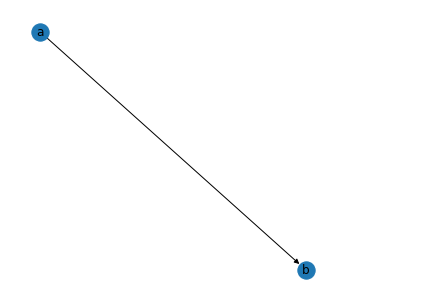

In [96]:
nx.draw(g, with_labels=True)

In [99]:
print([v for v in nx.readwrite.gml.generate_gml(g)])

['graph [', '  directed 1', '  node [', '    id 0', '    label "a"', '  ]', '  node [', '    id 1', '    label "b"', '  ]', '  edge [', '    source 0', '    target 1', '  ]', ']']


## Regression & dowhy things for the `linear_dataset`

* `v`: treatment
* `y`: outcome
* `w`: common cause
* `z`: instrument
* `x`: effect modifier

In [4]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=10000,
        treatment_is_binary=True)

In [5]:
df = data["df"]
df.head()

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,-1.086003,0.0,0.495702,-1.176136,-0.193731,-0.777935,1.083800,2.167303,True,10.557536
1,0.399027,0.0,0.771610,0.144692,-0.813339,-0.092532,0.673966,0.783751,True,12.773961
2,1.659474,0.0,0.508347,-0.449877,-0.792324,-2.133385,1.010700,0.296771,False,-4.150942
3,0.511381,1.0,0.901108,1.483755,-2.143687,-1.011555,-0.308896,-0.238366,True,8.023290
4,-0.062995,0.0,0.679842,0.143757,-1.813724,0.483968,-1.271378,0.524486,True,10.496115


Basic analysis

In [25]:
len(df)

In [16]:
c = df.corr(method='spearman'); c

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
X0,1.000000,-0.005358,-0.018007,-0.008313,-0.009183,-0.001161,0.014388,-0.004115,-0.016231,0.221996
Z0,-0.005358,1.000000,0.001928,-0.002149,-0.015322,-0.004246,-0.017817,0.011085,0.281243,0.143051
Z1,-0.018007,0.001928,1.000000,-0.001263,-0.006295,-0.008024,-0.006239,0.002534,0.291545,0.153600
W0,-0.008313,-0.002149,-0.001263,1.000000,0.010313,-0.019280,-0.005578,0.015516,0.346870,0.258484
W1,-0.009183,-0.015322,-0.006295,0.010313,1.000000,0.001782,0.008881,0.002058,0.216328,0.131609
W2,-0.001161,-0.004246,-0.008024,-0.019280,0.001782,1.000000,-0.005916,-0.016074,0.335805,0.595747
W3,0.014388,-0.017817,-0.006239,-0.005578,0.008881,-0.005916,1.000000,-0.002152,0.112269,0.246832
W4,-0.004115,0.011085,0.002534,0.015516,0.002058,-0.016074,-0.002152,1.000000,0.274983,0.430236
v0,-0.016231,0.281243,0.291545,0.346870,0.216328,0.335805,0.112269,0.274983,1.000000,0.815378
y,0.221996,0.143051,0.153600,0.258484,0.131609,0.595747,0.246832,0.430236,0.815378,1.000000


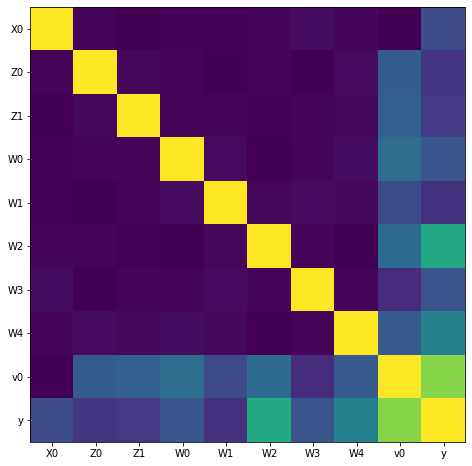

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(c)
ax.set(xticks=range(len(df.columns)), xticklabels=df.columns,
       yticks=range(len(df.columns)), yticklabels=df.columns)
plt.show()

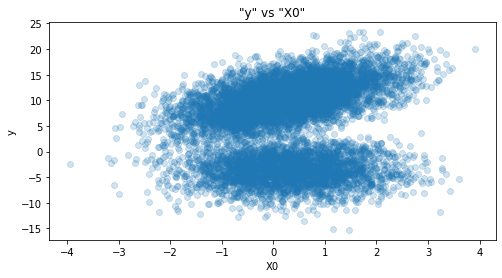

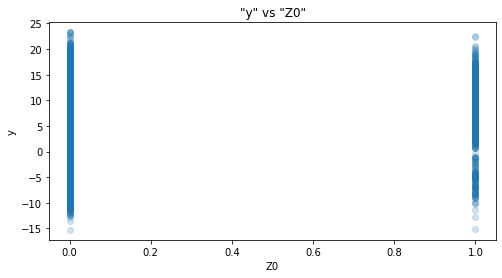

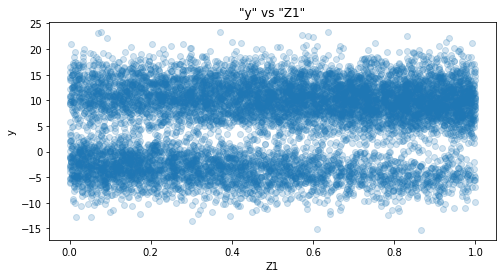

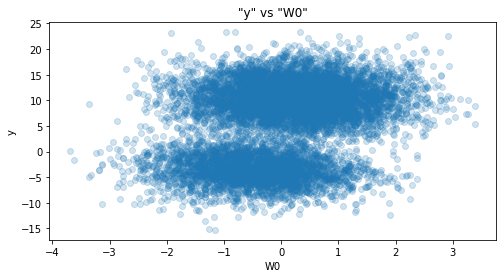

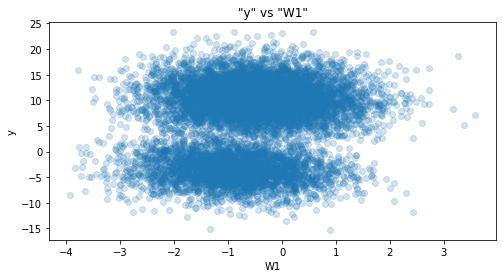

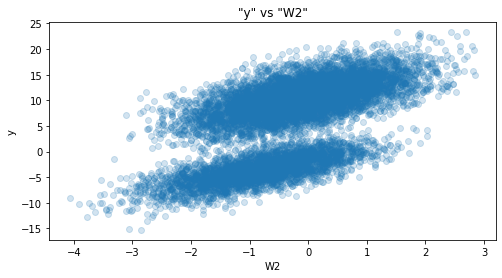

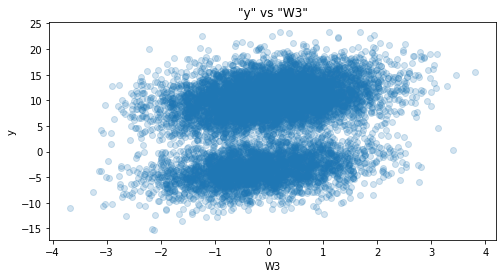

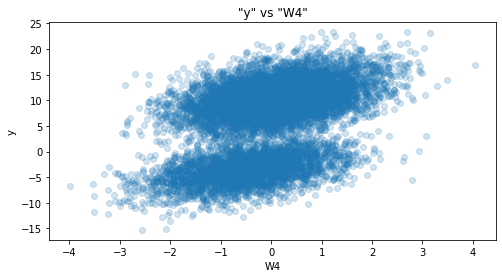

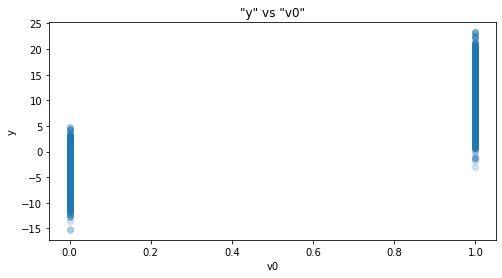

In [23]:
target = 'y'
for col in df.columns:
    if col == target: continue
    fig, ax = plt.subplots(figsize=(8,4))
    ax.scatter(col, target, data=df, alpha=.2)
    ax.set(xlabel=col, ylabel=target, title=f'"{target}" vs "{col}"')
    plt.show()

### Random forest and feature importance

In [65]:
x_cols = [col for col in df.columns if col != target]
X, y = df.loc[:, x_cols].values, df.loc[:, [target]].values.ravel()
m = ensemble.RandomForestRegressor(max_features='sqrt', n_estimators=100, oob_score=True)
m.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [66]:
m.oob_score_

In [67]:
def get_feature_importance(m, X:np.ndarray, y:np.ndarray, x_cols:list):
    n_obs, n_row = X.shape
    scores = {}
    for i in range(n_row):
        _X = X.copy()
        np.random.shuffle(_X[:,i])
        _y = m.predict(_X)
        scores[i] = metrics.mean_squared_error(y, _y)
        
    scores = pd.DataFrame([{'variable': x_cols[i], 'feature_importance': scores[i]} for i in scores]) 
    scores.sort_values('feature_importance', ascending=False, inplace=True)
    return scores

In [68]:
%%time
fi = get_feature_importance(m, X, y, x_cols)

CPU times: user 3.11 s, sys: 15.6 ms, total: 3.12 s
Wall time: 3.18 s


In [69]:
fi

,variable,feature_importance
8,v0,64.266035
5,W2,10.989869
7,W4,4.938898
0,X0,4.232863
6,W3,2.095849
3,W0,0.318268
2,Z1,0.232899
4,W1,0.164084
1,Z0,0.154739


In [83]:
_y = m.predict(X)

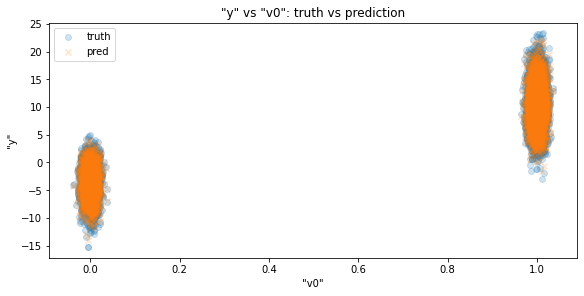

In [93]:
idp_var = 'v0'
ix = x_cols.index(idp_var)

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
jitter = np.random.normal(loc=0, scale=.01, size=len(y))
ax.scatter(X[:,ix]+jitter, y, label='truth', marker='o', alpha=.2)
ax.scatter(X[:,ix]+jitter, _y, label='pred', marker='x', alpha=.2)
ax.set(xlabel=f'"{idp_var}"', ylabel=f'"{target}"', 
       title=f'"{target}" vs "{idp_var}": truth vs prediction')
ax.legend(loc='best')
plt.show()

### dowhy things

In [70]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


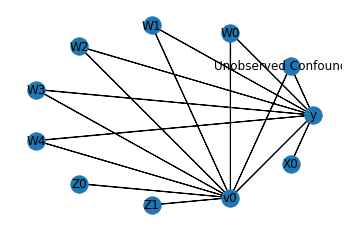

In [71]:
model.view_model()

Identification

In [73]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W0', 'Unobserved Confounders', 'W2', 'W1', 'W3', 'W4']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W2,W1,W3,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W1,W3,W4,U) = P(y|v0,W0,W2,W1,W3,W4)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



In [74]:
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name='backdoor.propensity_score_stratification')

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W2+W1+W3+W4
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [75]:
print(causal_estimate)

*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W2,W1,W3,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W1,W3,W4,U) = P(y|v0,W0,W2,W1,W3,W4)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W0+W2+W1+W3+W4
## Estimate
Value: 10.54603114678644



In [77]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W2+W1+W3+W4+w_random
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [78]:
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:(10.54603114678644,)
New effect:(10.534939738938057,)



In [79]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+W2+W1+W3+W4
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [80]:
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:(10.54603114678644,)
New effect:(0.07586933672652788,)



In [81]:
res_subset=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W2+W1+W3+W4
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/mnt/c/Programs_wsl/anaconda3/envs/py37_dowhy/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [82]:
print(res_subset)

Refute: Use a subset of data
Estimated effect:(10.54603114678644,)
New effect:(10.53364947062077,)

